In [1]:
# importing Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from datetime import datetime
import threading

## Group Assignment
### Team Number: 07
### Team Member Names: 
Sankalp Narula

Daniel Yan

Tanay Kashyap
### Team Strategy Chosen: SAFE

In [2]:
#Read in Tickers
df = pd.read_csv("Tickers.csv")

In [3]:
#If column name is a ticker, we make the column name into a ticker
first_ticker = df.columns[0]

In [4]:
#Rename Columns Properly
df.rename(columns = {first_ticker:"ticker"},inplace=True)

In [5]:
#Filter based on if regularMarketPrice exists for a certain stock or not
ab = yf.Ticker(first_ticker)
if ab.info["regularMarketPrice"] != None:
    df = df.append({"ticker":first_ticker},ignore_index=True)

In [6]:
# Remove any duplicates from the list
df = pd.DataFrame(list(dict.fromkeys(df.ticker)))

In [7]:
# renaming column names
df.rename(columns = {0:"ticker"},inplace=True)
df

,ticker
0,ABBV
1,ABT
2,ACN
3,AGN
4,AIG
...,...
57,UNH
58,UNP
59,UPS
60,USB


In [8]:
#Get length of dataframe
length = len(df)

In [9]:
## Downloading all the prices from yfinance at once
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = list(df.ticker),
        period = "5y",
        group_by = 'ticker',
        auto_adjust = True,
        threads = True,
        proxy = None)

[*********************100%***********************]  62 of 62 completed

4 Failed downloads:
- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted


In [10]:
# Function to download info from yfinance of ticker list 
inf = {}
l = 0
def get_info(ticker,start,end):
    global l
    for tick in ticker[start:end]:
        info = yf.Ticker(tick).info
        inf[tick] = info
        l+=100/length
        print("\rCompleted ",round(l,2),"%",end="")

In [11]:
# Multithreading Function to make the code more effecient
def split_processing(items,func, num_splits=20,split_size=100):                                      
    try:
        split_size = len(items) // num_splits 
    except:
        pass
    threads = []                                                                
    for i in range(num_splits):                                                 
        # determine the indices of the list this thread will handle             
        start = i * split_size                                                  
        # special case on the last chunk to account for uneven splits           
        end = None if i+1 == num_splits else (i+1) * split_size                 
        # create the thread                                                     
        threads.append(                                                         
            threading.Thread(target=func, args=(items,start,end)))         
        threads[-1].start() # start the thread we just created                  

    # wait for all threads to finish                                            
    for t in threads:                                                           
        t.join()
    print("\rCompleted", 100.00,"%",end="")

In [12]:
# Using Multithreading to download the info.
split_processing(df.ticker,get_info)

Completed 100.0 %%

In [13]:
#Check for delisted and non-existent stocks and creating a dictionary by combining all the data together for future use.
start_date = "2017-01-01"
dict2 = {}
pct = 0
global inf
for i in df.ticker:
    info = inf[i]
    a = data[i][data[i].index >= datetime.fromisoformat(start_date)]
    if not(np.isnan(a.Close.head(1).values[0])) and a.Close.head(1).values[0] > 0:
        dict2[i] = {"info":info,"price":a}
    pct+=100/length
    print("Completed", round(pct,2),"%",end="\r")

In [14]:
# Filter stocks based on currency and average share volume
filtered_stock_data = {}
for i,j in dict2.items():
    try:
        if j["info"]["currency"] == "USD" and np.mean(j["price"]["Volume"]) > 10000:
            filtered_stock_data[i]=j
        else:
            pass
    except KeyError:
        pass
len(filtered_stock_data)

54

In [15]:
#Calculate std of stock
def std_stock(stock):
    close=stock['price']['Close']
    std=close.pct_change().std()
    return std

In [16]:
#Create new dictionary with Ticker & STD of ticker using the std_stock func
dict3={}
for i,j in filtered_stock_data.items():
    dict3[i]= std_stock(j)
    
dict3

{'ABBV': 0.01756107686493507,
 'ABT': 0.01556053982246608,
 'ACN': 0.015498687363555317,
 'AIG': 0.02395940583147215,
 'AMZN': 0.018457595285798656,
 'AXP': 0.021596310773357684,
 'BA': 0.02946649778083313,
 'BAC': 0.021195656224560846,
 'BIIB': 0.029550075061342343,
 'BK': 0.018376255788687294,
 'BLK': 0.01801331626029113,
 'BMY': 0.015461384781413241,
 'C': 0.022994446534456682,
 'CAT': 0.019589728538342812,
 'CL': 0.012967394974496019,
 'CMCSA': 0.0166719250014217,
 'COF': 0.024760153685275618,
 'COP': 0.02625617136169143,
 'COST': 0.013294938674961357,
 'CSCO': 0.016952631830196928,
 'CVS': 0.017695411811342897,
 'GM': 0.023763788343879554,
 'GOOG': 0.016919948923984234,
 'JPM': 0.018892621863340477,
 'KMI': 0.01969029134274308,
 'KO': 0.012567161284454714,
 'LLY': 0.01742343192250157,
 'LMT': 0.015552353282001928,
 'MO': 0.015918598285072083,
 'MRK': 0.014098779147258858,
 'MS': 0.02118828474056482,
 'MSFT': 0.01718089829911213,
 'NEE': 0.014920620972845586,
 'NKE': 0.018275178350

In [17]:
temp_dict = dict3.copy()

In [18]:
temp_dict

{'ABBV': 0.01756107686493507,
 'ABT': 0.01556053982246608,
 'ACN': 0.015498687363555317,
 'AIG': 0.02395940583147215,
 'AMZN': 0.018457595285798656,
 'AXP': 0.021596310773357684,
 'BA': 0.02946649778083313,
 'BAC': 0.021195656224560846,
 'BIIB': 0.029550075061342343,
 'BK': 0.018376255788687294,
 'BLK': 0.01801331626029113,
 'BMY': 0.015461384781413241,
 'C': 0.022994446534456682,
 'CAT': 0.019589728538342812,
 'CL': 0.012967394974496019,
 'CMCSA': 0.0166719250014217,
 'COF': 0.024760153685275618,
 'COP': 0.02625617136169143,
 'COST': 0.013294938674961357,
 'CSCO': 0.016952631830196928,
 'CVS': 0.017695411811342897,
 'GM': 0.023763788343879554,
 'GOOG': 0.016919948923984234,
 'JPM': 0.018892621863340477,
 'KMI': 0.01969029134274308,
 'KO': 0.012567161284454714,
 'LLY': 0.01742343192250157,
 'LMT': 0.015552353282001928,
 'MO': 0.015918598285072083,
 'MRK': 0.014098779147258858,
 'MS': 0.02118828474056482,
 'MSFT': 0.01718089829911213,
 'NEE': 0.014920620972845586,
 'NKE': 0.018275178350

In [19]:
min(temp_dict.values())

0.012567161284454714

In [20]:
temp_dict

{'ABBV': 0.01756107686493507,
 'ABT': 0.01556053982246608,
 'ACN': 0.015498687363555317,
 'AIG': 0.02395940583147215,
 'AMZN': 0.018457595285798656,
 'AXP': 0.021596310773357684,
 'BA': 0.02946649778083313,
 'BAC': 0.021195656224560846,
 'BIIB': 0.029550075061342343,
 'BK': 0.018376255788687294,
 'BLK': 0.01801331626029113,
 'BMY': 0.015461384781413241,
 'C': 0.022994446534456682,
 'CAT': 0.019589728538342812,
 'CL': 0.012967394974496019,
 'CMCSA': 0.0166719250014217,
 'COF': 0.024760153685275618,
 'COP': 0.02625617136169143,
 'COST': 0.013294938674961357,
 'CSCO': 0.016952631830196928,
 'CVS': 0.017695411811342897,
 'GM': 0.023763788343879554,
 'GOOG': 0.016919948923984234,
 'JPM': 0.018892621863340477,
 'KMI': 0.01969029134274308,
 'KO': 0.012567161284454714,
 'LLY': 0.01742343192250157,
 'LMT': 0.015552353282001928,
 'MO': 0.015918598285072083,
 'MRK': 0.014098779147258858,
 'MS': 0.02118828474056482,
 'MSFT': 0.01718089829911213,
 'NEE': 0.014920620972845586,
 'NKE': 0.018275178350

In [21]:
#We create a function to sort and get the 15 least std values with keys
#n smallest standard deviation from dictionary
list_nsmallest = []
# temp_dict = dict3.copy()
while True:
    temp = min(temp_dict.values())
    res = [key for key in temp_dict if temp_dict[key] == temp]
    list_nsmallest.append(res[0])
    temp_dict.pop(res[0])
    if len(list_nsmallest) == 15:
        break

### Why we want low standard deviation:

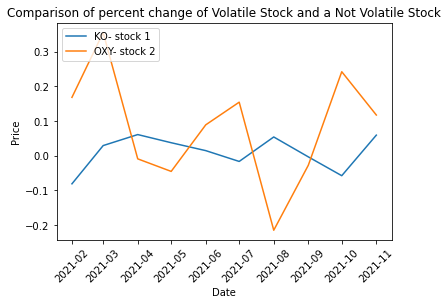

In [22]:
# stock1 = lowest std stock
stock1 = list_nsmallest[0]
temp = max(temp_dict.values())
for i,j in dict3.items():
    if j == temp:
        # stock 2 maximum std stock
        stock2 =i
High_Volatile_Ticker = yf.Ticker(stock1)
Low_Volatile_Ticker = yf.Ticker(stock2)
start_date = '2021-01-01'

high = High_Volatile_Ticker.history(start = start_date)
low = Low_Volatile_Ticker.history(start = start_date)

Compare = pd.DataFrame()
Compare[stock1] = high['Close']
Compare[stock2] = low['Close']
monethly_prices = Compare.resample('MS').first()

plt.plot(monethly_prices[stock1].pct_change(), label=stock1+"- stock 1")
plt.plot(monethly_prices[stock2].pct_change(), label=stock2+ "- stock 2")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of percent change of Volatile Stock and a Not Volatile Stock")
plt.xticks(rotation=45)

plt.legend(loc="upper left")
plt.show()

In [23]:
print(dict3[stock1])

0.012567161284454714


In [24]:
print(dict3[stock2])

0.03678502792496446


We picked stock1 to be the stock with the lowest standard deviation on closing price and stock2 to be the stock with the highest standard deviation on closing price. By observing the graph, it appears that stock1 appears to be a lot less volatile than stock2. As we are picking the safe option, we would want the prices to trade in a narrow trading range, the standard deviation of the closing price is a great indication. Stocks with a higher standard deviation will have their prices change much dramatically, thus indicating a high volatility. Vise versa, stocks with a low standard deviation on their closing price indicate a low volatility. In this case, We are choosing 15 least volatile stocks like stock1 for our portfolio. Since their portfolio volatility would also be very low

In [25]:
res=list_nsmallest

In [26]:
res

['KO',
 'PG',
 'CL',
 'PEP',
 'COST',
 'MRK',
 'PFE',
 'T',
 'NEE',
 'BMY',
 'ACN',
 'SO',
 'LMT',
 'ABT',
 'MO']

In [27]:
# random number seed, this is to get same output every time
sum1=0
name_of_grp_members = "Sankalp"+"Tanay"+"Daniel"
for i in name_of_grp_members:
    sum1+=105*ord(i)
print(sum1)
np.random.seed(sum1)

18120


In [28]:
# All possible combinations of 10 stocks out of 15
def combinations(lst, depth, start=0, items=[]):
    if depth <= 0:
        return [items]
    out = []
    for i in range(start, len(lst)):
        out += combinations(lst, depth - 1, i + 1, items + [lst[i]])
    return out

In [29]:
n_comb = combinations(res, 10)

In [30]:
comb=[]
for i in n_comb:
    for j in range(2):
        np.random.shuffle(i)
#         print(i)
        comb.append(i)
        


### Covariance

Covariance provides a measure of the strength of the correlation between two variables.

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

### Correlation

Correlation is a pair wise concept use to determine the relation (strength) between two assets, it takes a standardised value between $-1$ and $1$

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

### Our idea of Calculating Correlation of the portfolio
Suppose a portfolio have 4 stocks W,X,Y,Z. We calculate correlation of each stock with the stock before and after and average out the sum of correlations by dividing with the toatl number of stocks.


\begin{align*}
COR(Portfolio)=\frac{COR(W,X)+COR(X,Y)+COR(Y,Z)+COR(Z,W)}{4}
\end{align*}


This method helps us determine the correlation of a particular portfolio

### Correlation for creating a Safe portfolio

To create a safe portfolio, we want negatively correlated stocks, but inorder to achieve that we need every succesive pair of stock to be negatively correlated. So, we take 15 stocks with least standard deviation and take every possible combination and shuffle it 5 times to get the one with the most negatively correlated using the formula above to calculate the correlation of the portfolio. This helps us achieve somewhat close to taking all the permutations 10 stocks out of 15, theoretically that is the best option but it have exponentially more calculations to do (around 20 billion Calculation) which significantly decreases the speed of our code.

Taking negatively correlated stocks and creating a portfolio out of them reduces the standard deviation of the whole prtfolio. This is mainly due to diversification, since it reduces the risk of a failing of a single company (Example - If the CEO of the company runs away to fiji after a scam, the stock price of the company will tank instantly but the final portfolio value would not change that much since we have multiple stock).  

In [31]:
#Function that checks correlation of all pairs and outputs a list of least correlated stocks so portfolio is as less volatile as possible
n=0
min1=10
a=[]
ans=None
comb_length = len(comb)
def corr_calc(comb,start,stop):
    global a
    global ans
    global n
    global min1
    for i in list(comb[start:stop]):
        for j in range(len(i)):
            b=[]
            if j == len(i)-1:
                monthly_returns_1 = dict2[i[j]]['price']['Close'].resample('MS').first()
                monthly_returns_2 = dict2[i[0]]['price']['Close'].resample('MS').first()
                b.append(pd.concat([monthly_returns_1,monthly_returns_2],join="inner",axis=1).corr().iat[0,1])
            else:
                monthly_returns_1 = dict2[i[j]]['price']['Close'].resample('MS').first().pct_change()
                monthly_returns_2 = dict2[i[j+1]]['price']['Close'].resample('MS').first().pct_change()
                b.append(pd.concat([monthly_returns_1,monthly_returns_2],join="inner",axis=1).corr().iat[0,1])
        avg = sum(b)/10
        if avg <= min1:
            min1 = avg
            n+=100/comb_length
    #         print(min1, i, n)
            print("\rCompleted", round(n,2),"%",end="")
            ans=i
        else:
            n+=100/comb_length
#             print("Completed", round(n,2),"%",end="\r")
    #         print(avg, n)
        a.append(avg)
#     print("\rCompleted", 100.00,"%",end="")
ans

In [32]:
split_processing(comb,corr_calc,num_splits=30)

Completed 100.0 % % 30.15 % %%%88.63 %

In [33]:
# sorting the the best 10 Stocks based on their standard deviation.
dict_with_std = {}
for i in ans:
    dict_with_std[i] = dict3[i]
sorted_x = dict(sorted(dict_with_std.items(), key=lambda x: x[1]))
sorted_final_list = list(sorted_x.keys())
sorted_final_list

['KO', 'PG', 'CL', 'PEP', 'MRK', 'PFE', 'T', 'SO', 'LMT', 'MO']

In [34]:
# Creating Dataframe of all closing prices of stocks
#Creating date variables
starting='2021-01-01'
now=datetime.now()
buy_on_date = now.strftime("%Y-%m-%d")

#Dictionary of the stock to stock price data
stock_prices={}

for i in (range(0,len(sorted_final_list))):
    stock_prices[sorted_final_list[i]]=pd.DataFrame(yf.Ticker(sorted_final_list[i]).history(start=starting,end=buy_on_date).Close)
    stock_prices[sorted_final_list[i]].columns=[sorted_final_list[i]+" Closing"]

# #Creating stock price dataframe
index_dataframe=stock_prices[sorted_final_list[0]]
for i in (range(1,len(sorted_final_list))):
    index_dataframe=pd.concat([index_dataframe,stock_prices[sorted_final_list[i]]],join='inner',axis=1)

#Output dataframe of closing prices
index_dataframe

,KO Closing,PG Closing,CL Closing,PEP Closing,MRK Closing,PFE Closing,T Closing,SO Closing,LMT Closing,MO Closing
Date,,,,,,,,,,
2021-01-04,51.544147,134.438965,82.446388,142.089081,75.252045,35.423965,26.872856,56.963764,337.282440,38.741848
2021-01-05,50.977520,135.297379,82.632133,142.512573,75.382172,35.789654,26.708553,57.338020,341.343842,38.665955
2021-01-06,49.355778,136.721558,80.412842,140.769333,76.571930,35.481701,27.228849,58.739082,340.600037,39.292049
2021-01-07,48.808674,135.443710,79.972900,140.316299,78.096298,35.664547,27.301874,58.671906,335.237030,39.633556
2021-01-08,49.902870,135.385162,80.510612,142.000427,77.176094,35.731911,26.958164,59.084545,328.924713,39.453320
...,...,...,...,...,...,...,...,...,...,...
2021-11-18,55.410000,147.119995,76.389999,163.419998,83.050003,51.410000,24.389999,61.630001,342.079987,44.009998
2021-11-19,55.130001,146.820007,77.199997,163.809998,80.699997,50.799999,24.129999,62.669998,341.440002,43.400002
2021-11-22,55.470001,147.800003,77.559998,164.149994,81.639999,51.200001,24.700001,63.119999,344.980011,43.990002


In [35]:
#Computing daily returns using log change
#This means a log change of +0.1 today and then -0.1 tomorrow will give you the same value of stock as yesterday. 
#This is not true if you simply compute percentage change.
daily_return = index_dataframe.pct_change().apply(lambda x: np.log(1+x))
daily_return=daily_return.iloc[1: ,:]

#print daily log change returns
daily_return

,KO Closing,PG Closing,CL Closing,PEP Closing,MRK Closing,PFE Closing,T Closing,SO Closing,LMT Closing,MO Closing
Date,,,,,,,,,,
2021-01-05,-0.011054,0.006365,0.002250,0.002976,0.001728,0.010270,-0.006133,0.006549,0.011970,-0.001961
2021-01-06,-0.032330,0.010471,-0.027225,-0.012308,0.015660,-0.008642,0.019293,0.024141,-0.002181,0.016063
2021-01-07,-0.011147,-0.009390,-0.005486,-0.003223,0.019712,0.005140,0.002678,-0.001144,-0.015871,0.008654
2021-01-08,0.022170,-0.000432,0.006701,0.011931,-0.011853,0.001887,-0.012669,0.007008,-0.019009,-0.004558
2021-01-11,-0.017378,-0.006796,-0.002553,-0.014602,0.023449,0.017090,-0.005182,-0.005864,0.004690,-0.005787
...,...,...,...,...,...,...,...,...,...,...
2021-11-18,-0.008983,0.000136,-0.015458,0.000306,0.005433,0.010559,-0.011009,-0.008724,0.000263,-0.009273
2021-11-19,-0.005066,-0.002041,0.010548,0.002384,-0.028704,-0.011936,-0.010717,0.016734,-0.001873,-0.013957
2021-11-22,0.006148,0.006653,0.004652,0.002073,0.011581,0.007843,0.023347,0.007155,0.010315,0.013503


In [36]:
#most volatile stock std
final_std = {}
for i in sorted_final_list:
    final_std[i] = dict3[i]
temp = max(final_std.values())
for i,j in final_std.items():
    if j == temp:
        # stock -  maximum std stock
        stock =i
high_volatile=daily_return[stock+ " Closing"].std()
high_volatile

0.013740139879800444

In [37]:
#std of whole portfolio
std_portfolio=(daily_return.std().sum())/len(sorted_final_list)
std_portfolio

0.011137841837561429

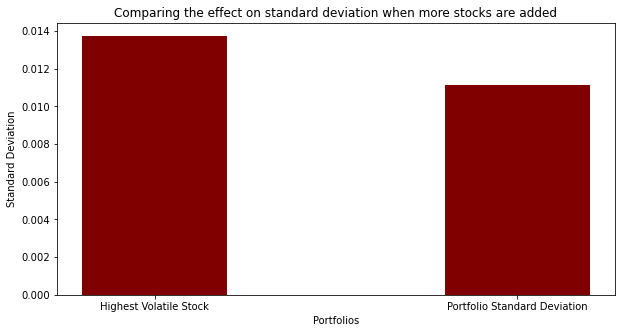

In [38]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['Highest Volatile Stock','Portfolio Standard Deviation'], [high_volatile,std_portfolio], color ='maroon',
        width = 0.4)
 
plt.xlabel("Portfolios")
plt.ylabel("Standard Deviation")
plt.title("Comparing the effect on standard deviation when more stocks are added")
plt.show()

In [39]:
print("Our final list of stocks consisted of a set of 10 somewhat negatively correlated stocks mixed in with those with the lowest standard deviations of the \'Tickers.csv\' file. Here the stock with the highest std in our stocks was " + stock +
", a pharmaceutical company that has seen minimal but greater than the other stocks on stocks in volatility. By itself in a portfolio, the standard deviation of that portfolio would be around *** " + str(round(high_volatile,2))+ " *** When the other stocks in stocks are added in, we see a decrease of *** "+ str(round((high_volatile-std_portfolio)/high_volatile*100,2))+"% *** in the standard deviation. This implies that a set of other negatively correlated and lower standard deviation stocks can infact decrease the risk of a portfolio and make it a more safer-portfolio for the end-consumer. ")

Our final list of stocks consisted of a set of 10 somewhat negatively correlated stocks mixed in with those with the lowest standard deviations of the 'Tickers.csv' file. Here the stock with the highest std in our stocks was MO, a pharmaceutical company that has seen minimal but greater than the other stocks on stocks in volatility. By itself in a portfolio, the standard deviation of that portfolio would be around *** 0.01 *** When the other stocks in stocks are added in, we see a decrease of *** 18.94% *** in the standard deviation. This implies that a set of other negatively correlated and lower standard deviation stocks can infact decrease the risk of a portfolio and make it a more safer-portfolio for the end-consumer. 


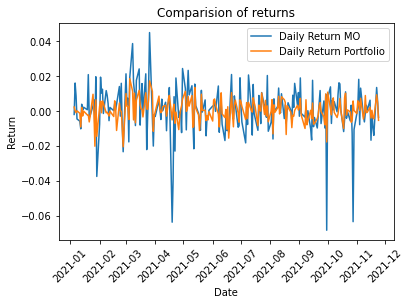

In [40]:
#Create a graph plotting returns of (highest volatile stock in list) vs the average returns of the whole list
plt.plot(daily_return[stock+' Closing'], label="Daily Return "+stock)
plt.plot(daily_return.sum(axis=1)/len(sorted_final_list), label="Daily Return Portfolio")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Comparision of returns")
plt.xticks(rotation=45)

plt.legend(loc='best')
plt.show()

By adding in a graph of the returns of `daily_return['Most Volatile Stock Closing']` and `daily_return` we can see  that the returns of Most Volatile Stock are greater from a daily standpoint then the returns of the whole portfolio and we see those big spikes that traders may have taken advantage of to make a hefty return through selling or shorting. The daily returns of the whole portfolio is seen as hidden in-between the daily returns of Most Volatile Stock and seen to be not as volatile. This come froms the above fact that the standard deviation of the whole portfolio less than Most Volatile Stock. This means there would is less movement on average in the returns for the whole portfolio, making it a great investment for a safe-value investor. 

Affluence Funds Management, an investment management firm based out in Brisbane studied the volatility characterisitcs of different investment types and came with a few findings that I feel resonate with our analysis. Obviously a single stock is more volatile then a basket of stocks from a concept called diversification. If we look at our list of stocks computed algorithmically using concepts from the MPT such as correlation, corvariance and standard deviation; we see that our list is comprised of stocks from different sectors that would react differently to an shock or minimal shock event. That in simple terms is the reasoning behind diversification. Our list comprises of a decent weightage of consumer stocks which are needed throughout any event humanity is facing. Through this diversification of stocks we have mitigated unsystematic risk. 

In [41]:
# Log of percentage change
cov_matrix = index_dataframe.pct_change().apply(lambda x: np.log(1+x)).cov()

#Print covariance matrix
cov_matrix

,KO Closing,PG Closing,CL Closing,PEP Closing,MRK Closing,PFE Closing,T Closing,SO Closing,LMT Closing,MO Closing
KO Closing,0.000074,0.000041,0.000045,0.000050,0.000022,0.000022,0.000029,0.000033,0.000026,0.000037
PG Closing,0.000041,0.000077,0.000049,0.000054,0.000029,0.000030,0.000028,0.000044,0.000018,0.000041
CL Closing,0.000045,0.000049,0.000081,0.000049,0.000022,0.000022,0.000027,0.000042,0.000018,0.000033
PEP Closing,0.000050,0.000054,0.000049,0.000079,0.000020,0.000028,0.000023,0.000039,0.000018,0.000033
MRK Closing,0.000022,0.000029,0.000022,0.000020,0.000218,0.000015,0.000022,0.000021,0.000014,0.000018
PFE Closing,0.000022,0.000030,0.000022,0.000028,0.000015,0.000203,0.000032,0.000029,0.000015,0.000039
T Closing,0.000029,0.000028,0.000027,0.000023,0.000022,0.000032,0.000115,0.000029,0.000034,0.000040
SO Closing,0.000033,0.000044,0.000042,0.000039,0.000021,0.000029,0.000029,0.000095,0.000024,0.000043
LMT Closing,0.000026,0.000018,0.000018,0.000018,0.000014,0.000015,0.000034,0.000024,0.000169,0.000048
MO Closing,0.000037,0.000041,0.000033,0.000033,0.000018,0.000039,0.000040,0.000043,0.000048,0.000189


In [42]:
#Average Yearly Returns For Individual Companies 
yr_er=daily_return.resample('Y').last().mean()

#Print returns
yr_er

KO Closing    -0.008086
PG Closing    -0.005233
CL Closing    -0.002184
PEP Closing   -0.009180
MRK Closing   -0.006300
PFE Closing   -0.003727
T Closing     -0.011782
SO Closing     0.001427
LMT Closing   -0.004646
MO Closing    -0.003623
dtype: float64

### Calculating the most optimal weight
Finally, we want to find the most optimal weights for the 10 stocks that we have chosen. We would want to find the best weight distribution so that our average return would be as close to zero as possible. In order to do so, we have constructed 10,000 randomly generated possible combinations of weights and filtered the weights to be at least 5 percent of our investment but no more than 35 percent. This reduces the amount of possible combinations to work with, such that we are able to calculate the volatility of each possibility with relative efficiency. Then, we pick the one with the least volatility of the final portfolio and set that weight to be our final weight distribution for our portfolio.

In [43]:
portfolio_returns=[] # Empty Array for Portfolio Returns
portfolio_volatility=[] #Empty Array for Portfolio Volatility
portfolio_weights=[] #Empty Array for Asset Weights

num_assets=len(daily_return.columns)
num_portfolios=10000 #Create as much portfolios as possible

In [44]:
# This for-loop computers the returns,volatilty and invidual weights for each portfolio
for portfolio in range(num_portfolios):
    weights=np.random.random(num_assets)
    weights=weights/np.sum(weights)
    portfolio_weights.append(weights)
    returns=np.dot(weights,yr_er) #Expected returns are product of individual expected returns x weights
    portfolio_returns.append(returns)
    var=cov_matrix.mul(weights,axis=0).mul(weights,axis=1).sum().sum() #Portfolio Variance
    sd=np.sqrt(var) # Daily Standard Deviation
    ann_sd=sd*np.sqrt(175) # Annual Standard Deviation = volatility (used 175 thats because thats the # of range of our data)(should be 250 but we don't even have a full year of expected returns)
    portfolio_volatility.append(ann_sd)

In [45]:
data={'Returns':portfolio_returns,'Volatility':portfolio_volatility}

for counter, symbol in enumerate(daily_return.columns.tolist()):
    data[symbol+' weight']=[w[counter] for w in portfolio_weights]

In [46]:
portfolios=pd.DataFrame(data)
portfolios #Dataframe of the 10k portfolios created

,Returns,Volatility,KO Closing weight,PG Closing weight,CL Closing weight,PEP Closing weight,MRK Closing weight,PFE Closing weight,T Closing weight,SO Closing weight,LMT Closing weight,MO Closing weight
0,-0.005455,0.086214,0.055163,0.111371,0.144661,0.110400,0.170720,0.094948,0.095968,0.061743,0.062186,0.092841
1,-0.006039,0.088232,0.151143,0.090266,0.062584,0.037959,0.127689,0.141292,0.130785,0.008570,0.092641,0.157070
2,-0.006210,0.084724,0.119506,0.172856,0.084051,0.055726,0.080195,0.129113,0.189957,0.057191,0.095753,0.015652
3,-0.005442,0.084218,0.054599,0.118896,0.091592,0.136333,0.105036,0.105968,0.110569,0.107937,0.106998,0.062072
4,-0.003849,0.091102,0.093723,0.217555,0.193615,0.042823,0.001499,0.025128,0.026405,0.161446,0.089179,0.148627
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.005520,0.086056,0.023266,0.109287,0.053646,0.100080,0.064633,0.099016,0.182011,0.133968,0.143416,0.090677
9996,-0.005409,0.092872,0.052677,0.068436,0.176934,0.158522,0.277543,0.071949,0.073323,0.107602,0.009296,0.003718
9997,-0.005625,0.087177,0.056201,0.026616,0.073570,0.229900,0.165676,0.047461,0.055292,0.116843,0.222046,0.006395
9998,-0.005511,0.087769,0.077261,0.124005,0.137436,0.133720,0.145728,0.142065,0.051010,0.015088,0.052445,0.121242


In [47]:
#Filter dataframe so it fits the weight restrictions of min of (100/2n) & and max of 35%
filterinfDataframe = portfolios[(portfolios[portfolios.columns[2]] >= 0.05) & (portfolios[portfolios.columns[2]] <= 0.35) &
                                (portfolios[portfolios.columns[3]] >= 0.05) & (portfolios[portfolios.columns[3]] <= 0.35) &
                                (portfolios[portfolios.columns[4]] >= 0.05) & (portfolios[portfolios.columns[4]] <= 0.35) &
                                (portfolios[portfolios.columns[5]] >= 0.05) & (portfolios[portfolios.columns[5]] <= 0.35) &
                                (portfolios[portfolios.columns[6]] >= 0.05) & (portfolios[portfolios.columns[6]] <= 0.35) &
                                (portfolios[portfolios.columns[7]] >= 0.05) & (portfolios[portfolios.columns[7]] <= 0.35) &
                                (portfolios[portfolios.columns[8]] >= 0.05) & (portfolios[portfolios.columns[8]] <= 0.35) &
                                (portfolios[portfolios.columns[9]] >= 0.05) & (portfolios[portfolios.columns[9]] <= 0.35) &
                                (portfolios[portfolios.columns[10]] >= 0.05) & (portfolios[portfolios.columns[10]] <= 0.35) &
                                (portfolios[portfolios.columns[11]] >= 0.05) & (portfolios[portfolios.columns[11]] <= 0.35)
                               ]
#Reset index to start from 0
filterinfDataframe.reset_index(inplace=True)
#Print dataframe
filterinfDataframe

,index,Returns,Volatility,KO Closing weight,PG Closing weight,CL Closing weight,PEP Closing weight,MRK Closing weight,PFE Closing weight,T Closing weight,SO Closing weight,LMT Closing weight,MO Closing weight
0,0,-0.005455,0.086214,0.055163,0.111371,0.144661,0.110400,0.170720,0.094948,0.095968,0.061743,0.062186,0.092841
1,3,-0.005442,0.084218,0.054599,0.118896,0.091592,0.136333,0.105036,0.105968,0.110569,0.107937,0.106998,0.062072
2,9,-0.005652,0.084899,0.125459,0.091335,0.094345,0.099247,0.137278,0.079128,0.112673,0.091520,0.071458,0.097559
3,34,-0.004254,0.086414,0.067683,0.055678,0.143077,0.052721,0.147435,0.076761,0.083476,0.197855,0.066346,0.108970
4,41,-0.005625,0.085827,0.109975,0.061213,0.099187,0.141908,0.093861,0.090660,0.104009,0.083139,0.076126,0.139921
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,9819,-0.005325,0.085044,0.143360,0.079100,0.143804,0.131796,0.100242,0.080464,0.073016,0.102774,0.054388,0.091055
290,9845,-0.005276,0.086730,0.059912,0.124070,0.065746,0.132321,0.106051,0.182020,0.069633,0.083927,0.095824,0.080497
291,9886,-0.004768,0.085902,0.088907,0.055782,0.067057,0.098529,0.143374,0.155301,0.059054,0.155822,0.109899,0.066276
292,9891,-0.005235,0.084869,0.080129,0.081516,0.109783,0.136340,0.136579,0.101957,0.072753,0.106608,0.089680,0.084654


In [48]:
#Filter dataframe to get the portfolio with lowest volatility from the above dataframe
min_vol_portfolio=filterinfDataframe.iloc[filterinfDataframe['Volatility'].idxmin()]
#drop the volatility,returns and extra index columns
all_weights=min_vol_portfolio.drop(min_vol_portfolio.index[[0,1,2]])
#output weights
all_weights

KO Closing weight     0.124578
PG Closing weight     0.080179
CL Closing weight     0.093207
PEP Closing weight    0.088867
MRK Closing weight    0.113232
PFE Closing weight    0.091722
T Closing weight      0.125620
SO Closing weight     0.098493
LMT Closing weight    0.129272
MO Closing weight     0.054831
Name: 137, dtype: float64

In [49]:
#Capital 
starting_money = 100000
#For calculating range
num_of_stocks=len(all_weights)
#output number of stocks
num_of_stocks

10

In [50]:
# This for-loop computers the shares of each ticker based on the weights and capital computed and given
final_shares_dict={}
buying_date = '2021-11-26'
for i in range(num_of_stocks):
    #Remeber to change '2021-11-24' to '2021-11-26' before submitting
    try:
        shares=(starting_money*all_weights[i])/(filtered_stock_data[ans[i]]["price"]["Close"][buying_date])
        final_shares_dict[ans[i]]=shares
    except:
        shares=(starting_money*all_weights[i])/(filtered_stock_data[ans[i]]["price"]["Close"]["2021-11-24"])
        final_shares_dict[ans[i]]=shares
#Output Tickers & Shares
final_shares_dict

{'MRK': 157.37461834869632,
 'PEP': 49.757045285520654,
 'CL': 120.95346490472411,
 'KO': 165.39616066594564,
 'PG': 76.78340253251974,
 'SO': 147.8430282068573,
 'PFE': 232.62875158866052,
 'T': 406.6582546541308,
 'LMT': 37.7193972869482,
 'MO': 125.35728490398405}

In [51]:
#Store tickers
ticker=final_shares_dict.keys()
#Store the closing prices of each stock on '2021-11-26' (remeber to change price value to '2021-11-26')
try:
    price=[filtered_stock_data[ans[i]]["price"]["Close"][buying_date] for i in range(num_of_stocks)]
except:
    price=[filtered_stock_data[ans[i]]["price"]["Close"]["2021-11-24"] for i in range(num_of_stocks)]

# convert the shares into a list
shares=list(final_shares_dict.values())
#Compute value of allocation of each stock by price*shares
value=[a*b for a,b in zip(price,shares)]
#List of weights
weight=list(all_weights)

In [52]:
#Create a dataframe that holds the ticker,price,shares,value & weight
FinalPortfolio=pd.DataFrame([ticker,price,shares,value,weight]).T
#start index from 1-10
FinalPortfolio.index+=1
#rename columns
FinalPortfolio.columns=['Ticker','Price','Shares','Value','Weight']

In [53]:
#Showing Weights & Portfolio Equal 100% and 100k Respectively 
total_weight=FinalPortfolio['Weight'].sum()
total_value=FinalPortfolio['Value'].sum()

In [54]:
#Printing proof of total weight summation
print("Total Weight Of Portfolio: ",total_weight)

Total Weight Of Portfolio:  1.0


In [55]:
#Print proof o total value of portfolio
print("Total Value Of Portfolio: ",total_value)

Total Value Of Portfolio:  99999.99999999999


In [57]:
#Create final dataframe to hold tickers and shares
Stocks = pd.DataFrame(final_shares_dict.values(),final_shares_dict.keys())
#reset index
Stocks.reset_index(inplace=True)
#start index from 1-10
Stocks.index+=1
#rename columns
Stocks.rename(columns={"index":"Ticker",0:"Shares"},inplace=True)
#output dataframe to csv file
Stocks.to_csv("Stocks_Group_07.csv")
#Print Tickers & Shares (Stocks Dataframe)
Stocks

,Ticker,Shares
1,MRK,157.374618
2,PEP,49.757045
3,CL,120.953465
4,KO,165.396161
5,PG,76.783403
6,SO,147.843028
7,PFE,232.628752
8,T,406.658255
9,LMT,37.719397
10,MO,125.357285


In [58]:
#Print Final Portfolio
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,MRK,79.160004,157.374618,12457.775365,0.124578
2,PEP,161.139999,49.757045,8017.850247,0.080179
3,CL,77.059998,120.953465,9320.67371,0.093207
4,KO,53.73,165.396161,8886.735637,0.088867
5,PG,147.470001,76.783403,11323.248465,0.113232
6,SO,62.040001,147.843028,9172.181605,0.091722
7,PFE,54.0,232.628752,12561.952586,0.12562
8,T,24.219999,406.658255,9849.262648,0.098493
9,LMT,342.720001,37.719397,12927.191884,0.129272
10,MO,43.740002,125.357285,5483.127852,0.054831


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Sankalp Narula, Tanay Kashyap, Daniel Yan